# Introduction : West Nile Virus
___

**Problem Statement**

1. Given weather, location, testing, and spraying data, predict when and where different species of mosquitos will test positive for West Nile virus. 
2. Is pesticide effective : Population before 2011 vs Population After 2013.


**Key variables**

|Data|Description|
|---|---|
|Id|Id of the Mosquito|
|Species|Species of Mosquito|
|Address|Location of Trap|
|Block| Block nunber of address|
|Street| Street Name|
|Trap ID| Id of Trap. Letter behind Trap ID indicate it is near a main Trap|
|Latitude , Longtitude|Location of Trap , Mosquito|
|NumMosquito| No. of Mosquito|
|WNV_Present| 1 means WNV is present, and 0 means not present|
|Spray CSV| Latitude , Longtitude. Dataset only at 2011, 2013|

**Model Explored**

**workflow**
1. EDA
2. Feature Engineering 
3. Data Preprocessing
4. Modelling to predict WNV probability (without pesticide)
5. Select best Model to study the effect of pesticide
  * 5.1 Hypothesis : Pesticide has no effect on Mosquito population

**Key Insight**

We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!  


# 0.0 Libraries Import
___

In [1]:
# # installing less common packages (uncomment if you do not have these installed)
#!pip install geopy
!pip install geopandas
!pip install featuretools

In [2]:
# import libraries
import pandas as pd, numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits import mplot3d
import seaborn as sns

import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

import featuretools as ft

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline




# 1.0 Data Import
___

In [3]:
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/test.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/spray.csv

--2021-10-21 11:25:13--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797335 (1.7M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   1.71M  --.-KB/s    in 0.04s   

2021-10-21 11:25:13 (42.1 MB/s) - ‘train.csv.1’ saved [1797335/1797335]

--2021-10-21 11:25:13--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [4]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_spray = pd.read_csv('/content/spray.csv')
df_weather = pd.read_csv('/content/weather.csv')

In [5]:
df_train

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


df_weather

In [6]:
df_spray

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
...,...,...,...,...
14830,2013-09-05,8:34:11 PM,42.006587,-87.812355
14831,2013-09-05,8:35:01 PM,42.006192,-87.816015
14832,2013-09-05,8:35:21 PM,42.006022,-87.817392
14833,2013-09-05,8:35:31 PM,42.005453,-87.817423


# 2.0 EDA (Basic EDA)
___

### 2.1 Effect of Spray and Distance(Julian)
___

In [45]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_spray['Date'] = pd.to_datetime(df_spray['Date'])

In [8]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [9]:
dfs = [
    (df_train, 'trap'),
    (df_spray, 'spray'),
    (df_weather, 'weather'),
    (df_test, 'test')
    ]

In [10]:
[basic_eda(df, name) for df, name in dfs]

TRAP

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object
-----

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
P

[None, None, None, None]

# Traps
This dataframe contains information associated with each mosquito trap deployed across the city of Chicago. The location of the traps are described by the block number and street name which have been conveniently mapped into Latitude and Longitude.

In [11]:
print(df_train.Date.min())
print(df_train.Date.max())
df_train.head()

2007-05-29 00:00:00
2013-09-26 00:00:00


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


# Mosquito species
Although all species sampled are carriers of WNV, the presence of WNV was tested positive for Culex restuans, C. pipiens, and C.pipiens/restuans. In addition, these 3 categories made up more than 96% of the sample of the species sampled.

(https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf).

In [12]:
# what species are there
print(f'number of species: {df_train["Species"].nunique()}')
df_train["Species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

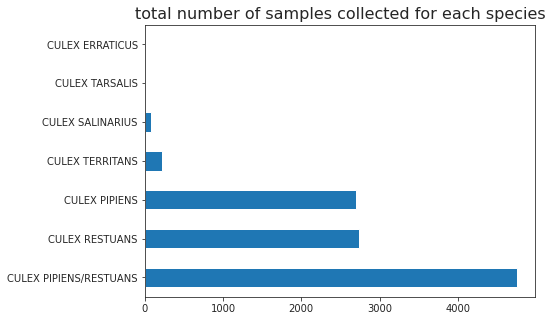

In [13]:
df_train['Species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16);

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


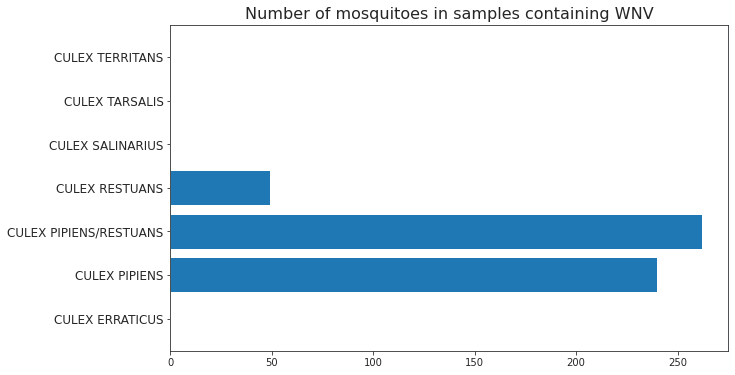

In [14]:
mos_wnv = df_train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

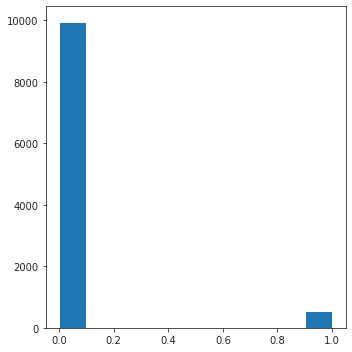

In [15]:
plt.figure(figsize=(5,5))
plt.hist(df_train.WnvPresent)
# plt.title('WNV presence by mosquito species', fontsize=16)
# plt.yticks(fontsize=12)
# plt.ylabel('')
# plt.xlabel('Total number of mosquitos',fontsize=14)
plt.tight_layout()

# Add datetime columns

In [16]:
# make datetime columns
df_train['Year'] = df_train['Date'].apply(lambda x:x.year)
df_train['Month'] = df_train['Date'].apply(lambda x:x.month)
df_train['WeekofYear'] = df_train['Date'].apply(lambda x:x.weekofyear)
df_train['YearMonth'] = df_train['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# year 2007 - 2013
print(df_train.Year.value_counts().sort_index().head(),'\n')

# data only from may - oct
print(df_train.Month.value_counts().head(),'\n')

# week 22 - 41
print(df_train.WeekofYear.value_counts().sort_index().head(),'\n')

# total number of weeks in dataset
print('total number of weeks in dataset:',df_train.WeekofYear.nunique())

2007    3811
2009    2249
2011    2054
2013    2392
Name: Year, dtype: int64 

8     3751
7     2606
9     2218
6     1571
10     276
Name: Month, dtype: int64 

22     84
23    383
24    321
25    332
26    504
Name: WeekofYear, dtype: int64 

total number of weeks in dataset: 20


# Combine mosquito counts
As the test results are organized in a way that the number of mosquitoes are capped at 50 for each record even when the samples are collected on the same day. We will combine these records into a single record.

In [17]:
df_train.shape

(10506, 16)

In [18]:
df_train = df_train.groupby([col for col in df_train.columns if col not in ['NumMosquitos']]).sum()
df_train.reset_index(inplace=True)

In [19]:
df_train.shape

(8610, 16)

# Number of traps and sampling effort

In [20]:
df_train.Trap.nunique()

136

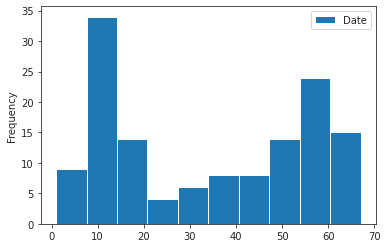

In [21]:
df_train[['Date','Trap']].groupby(['Trap']).nunique().plot(kind='hist');

There are 136 traps.
T900 (at Ohare airport) is sampled the most

In [22]:
print('Trap with the most sampling:', df_train[['Date','Trap']]\
      .groupby(['Trap']).nunique().idxmax().values[0], 'frequency',\
      df_train[['Date','Trap']].groupby(['Trap']).nunique().max().values[0])

Trap with the most sampling: T002 frequency 67


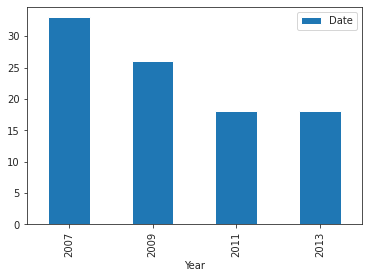

In [23]:
df_train[['Year','Date']].groupby(['Year']).nunique().plot(kind='bar');

Most sampling was performed in 2007 and decreased afterward

# Duplicate addresses for each trap

In [24]:
df_train[df_train.Trap=='T002']\
  .groupby(['AddressNumberAndStreet','Longitude','Latitude']).count()

,,,Date,Address,Species,Block,Street,Trap,AddressAccuracy,WnvPresent,Year,Month,WeekofYear,YearMonth,NumMosquitos
AddressNumberAndStreet,Longitude,Latitude,,,,,,,,,,,,,
"4100 N OAK PARK AVE, Chicago, IL",-87.800991,41.95469,150,150,150,150,150,150,150,150,150,150,150,150,150


In [25]:
df_train[['AddressNumberAndStreet','Trap']].groupby(['Trap']).nunique()\
    .sort_values(by='AddressNumberAndStreet',ascending=False).head(3)

,AddressNumberAndStreet
Trap,
T035,2
T009,2
T001,1



T035 is probably mislabelled for one of the addresses and T009 is probably a typo. Since coordinates are already present, trap numbers aren't important. Therefore all other location columns such as addresses and Trap will be dropped.

# Univariate EDA
## Distributions

In [26]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

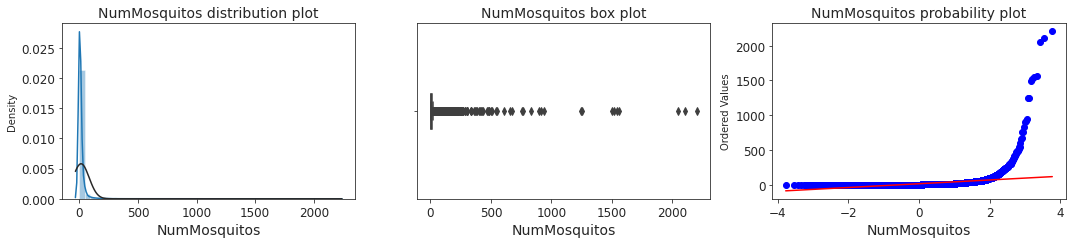

In [27]:
dist_plots(df_train, ['NumMosquitos'])

# Clustering

In [28]:
def dbscan(df, list_of_columns, eps, min_samples):
    
    df_cluster = df[list_of_columns]

    minmax = MinMaxScaler(feature_range = (0, 1))

    clusters = minmax.fit_transform(df_cluster)

    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    dbs.fit(clusters)
    df['Cluster'] = dbs.labels_
    vals = df['Cluster'].value_counts()
    print(f'Silhouette Score: {silhouette_score(clusters, dbs.labels_)}')
    print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(df):.2f}% of samples)')
    print(f'Number of clusters: {len(vals)}')

    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['Latitude'], df['Longitude'], df['NumMosquitos'], c = df['Cluster'], cmap = 'rainbow')
    ax.set_title(f'DBSCAN for {list_of_columns}\n\u03B5 = {eps} Min. Clusters = {min_samples}')
    plt.show()

Silhouette Score: 0.7321141477472317
Number of outliers: 100 (2.17% of samples)
Number of clusters: 119


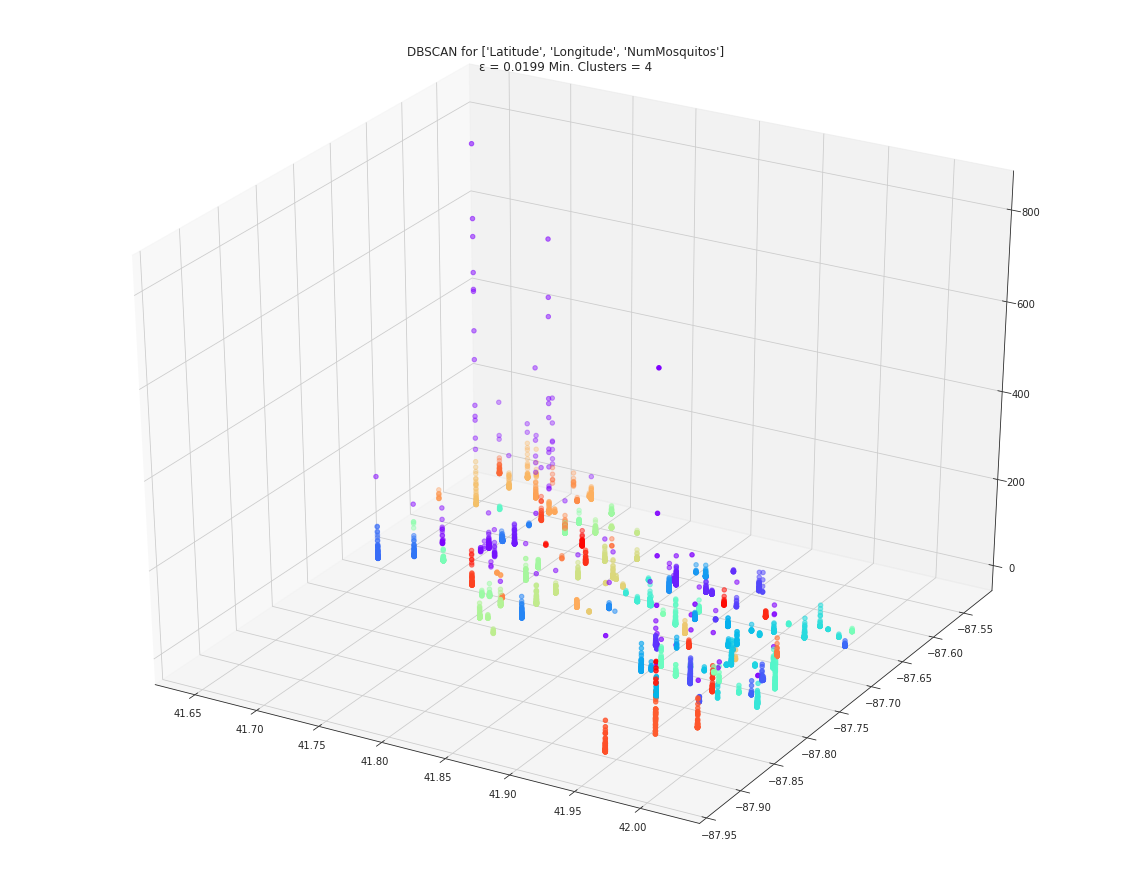

In [29]:
df_train['Coord'] = [(x, y) for x, y in zip(df_train['Latitude'], df_train['Longitude'])]

trap_cluster = df_train.groupby(['Date', 'Coord']).mean().copy()

dbscan(trap_cluster, ['Latitude', 'Longitude', 'NumMosquitos'], eps = 0.0199, min_samples = 4)

# Spray

## Handling null values and duplicates
Examine spray dataset for null values

In [30]:
spray1 = df_spray.copy()

In [31]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

Time data is probably too finely tuned for our needs, so we might drop Time from spray instead.

In [32]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].shape

(543, 4)

This will be assumed to be errors and will be dropped.

Spray data to drop:
- `Time` column
- duplicated rows

In [33]:
spray1.shape

(14835, 4)

In [34]:
df_spray = spray1.drop(columns='Time').drop_duplicates(keep='first')
df_spray.shape

(14294, 3)

Now, to find out

- number of unique spray dates  
- number of sprays made on each unique date

# of unique spray dates:  10 



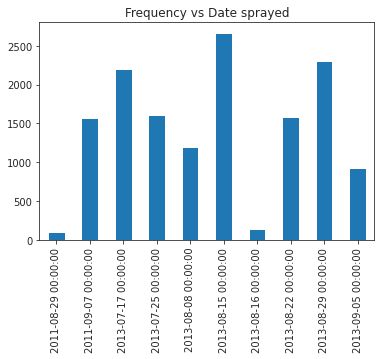

In [59]:
print('# of unique spray dates: ',df_spray["Date"].nunique(),'\n')
df_spray["Date"].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency vs Date sprayed');

Only sprayed 2 dates in 2011 and many more in 2013.

In 2013 it only starts in mid 2013-07 to start 2013-09. The pesticide may not have had strong penetration in 2011.  
Analysis for effective pesticide should start in 2014 and ignore effects in 2011

# Tracking nearest spray location for each trap record

In [36]:
# Create full list of trap locations
trap_loc = pd.concat([df_train[['Latitude','Longitude']],\
                  df_test[['Latitude','Longitude']]],axis=0).drop_duplicates()

# Set destinations of spray
df_spray['geom'] = [Point(x,y) for x,y in \
                    zip(df_spray.Latitude,df_spray.Longitude)]
destinations = MultiPoint(df_spray['geom'].tolist())

dist = []
for x,y in zip(trap_loc.Latitude, trap_loc.Longitude):
  # set location of trap
  orig = Point(x,y)

  # get distance
  # find nearest points
  nearest_geoms = nearest_points(orig, destinations)
  # measure trap to nearest spray
  a, b = (x, y) ,(nearest_geoms[1].x,nearest_geoms[1].y)
  dist.append(geodesic(a,b).m)



# add distance to trap locations
trap_loc['dist_spray'] = dist

In [37]:
# merge dist and train, test
df_train = df_train.merge(trap_loc,on=['Latitude','Longitude'])
df_test  = df_test.merge(trap_loc,on=['Latitude','Longitude'])

In [60]:
df_train['sprayed'] = df_train['dist_spray'].apply(lambda x: 0 if x > 500 else 1)

In [62]:
df_train.to_csv('df_train_dist.csv',index=False)